In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings


In [3]:
import pandas_datareader as pdr
import fix_yahoo_finance as yf
from pandas_datareader import data

In [4]:
sns.set_style('darkgrid')

In [5]:
#Collecting microsoft data 
data = yf.download('MSFT','2014-01-01','2020-01-01')
data.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,37.400002,37.580002,37.220001,37.410000,32.690006,17503500
2014-01-02,37.349998,37.400002,37.099998,37.160000,32.471554,30632200
2014-01-03,37.200001,37.220001,36.599998,36.910000,32.253098,31134800
2014-01-06,36.849998,36.889999,36.110001,36.130001,31.571505,43603700
2014-01-07,36.330002,36.490002,36.209999,36.410000,31.816179,35802800


In [6]:
data.index #to check the date format

DatetimeIndex(['2013-12-31', '2014-01-02', '2014-01-03', '2014-01-06',
               '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10',
               '2014-01-13', '2014-01-14',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=1511, freq=None)

In [7]:
data['Year'] = data.index.year

In [8]:
data['Month'] = data.index.month
data['day'] = data.index.day

In [9]:
# Display a random sampling of 5 rows
data.sample(5, random_state=0)

,Open,High,Low,Close,Adj Close,Volume,Year,Month,day
Date,,,,,,,,,
2015-11-03,52.930000,54.389999,52.900002,54.150002,49.602730,36596900,2015,11,3
2014-03-19,39.470001,39.549999,38.910000,39.270000,34.572651,35597200,2014,3,19
2014-02-20,37.570000,37.869999,37.400002,37.750000,33.234486,27526100,2014,2,20
2017-10-03,74.669998,74.879997,74.190002,74.260002,71.573280,12190400,2017,10,3
2014-01-14,34.730000,35.880001,34.630001,35.779999,31.265663,41623300,2014,1,14


### Exploration of Data

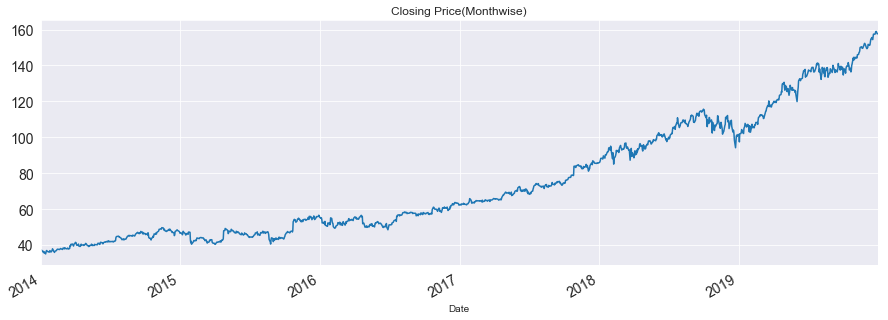

In [10]:
temp = data.groupby(['Date'])['Close'].mean()
temp.plot(figsize=(15,5), title='Closing Price(Monthwise)', fontsize = 14)
plt.show()

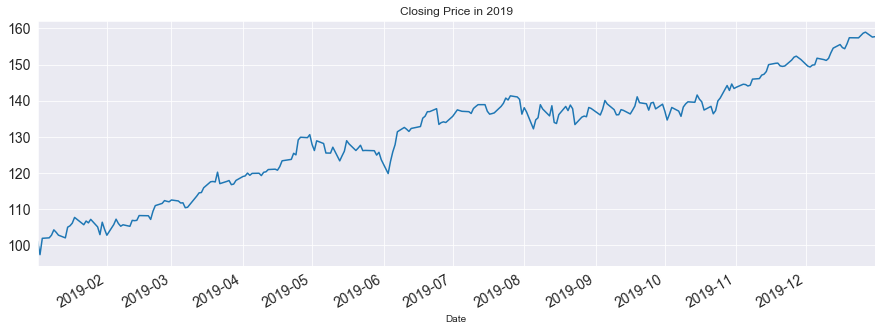

In [11]:
data[data['Year']==2019]['Close'].plot(figsize=(15,5), title='Closing Price in 2019',fontsize=14)
plt.show()

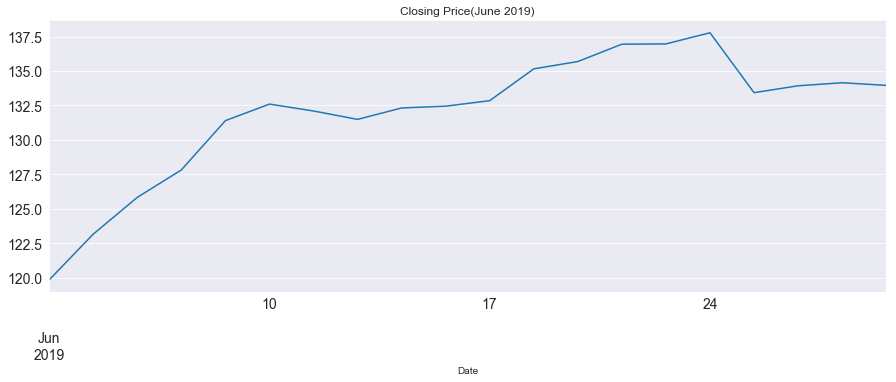

In [12]:
temp2=data[data['Year']==2019][data[data['Year']==2019]["Month"]==6]['Close']
temp2.plot(figsize=(15,5), title='Closing Price(June 2019)', fontsize = 14)
plt.show()


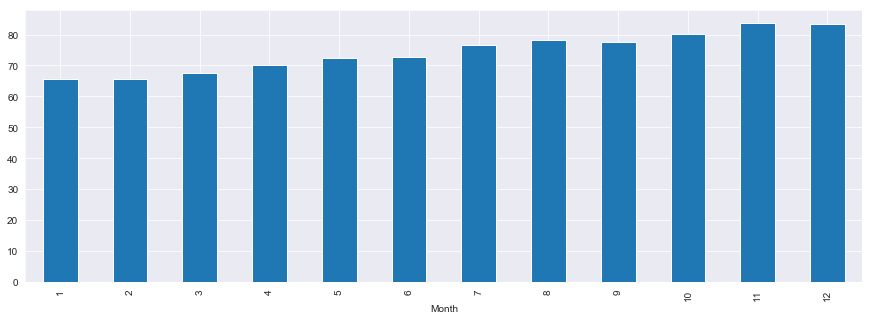

In [13]:
data.groupby(['Month'])['Close'].mean().plot.bar(figsize=(15,5))

In [14]:
test=data.loc['2019-01-01':]

In [15]:
train = data.loc[:'2019-01-01']


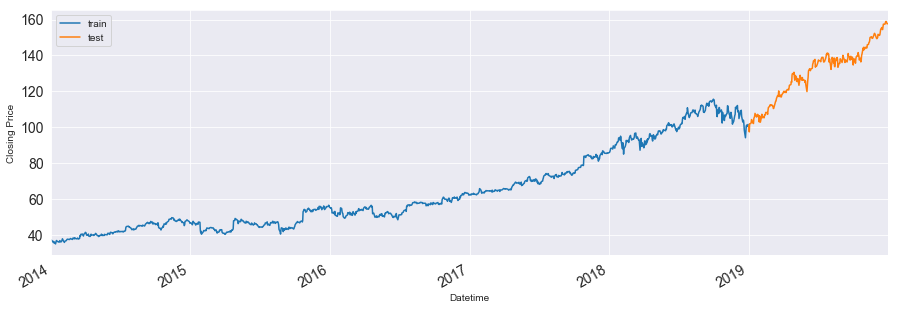

In [16]:
train.groupby(['Date'])['Close'].mean().plot(figsize = (15,5),label ='train',fontsize=14)
test.groupby(['Date'])['Close'].mean().plot(figsize = (15,5), label ='test', fontsize =14)
plt.xlabel("Datetime")
plt.ylabel('Closing Price')
plt.legend(loc='best')
plt.show()

In [17]:
## To test for stationary we will be using Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller

In [18]:
def test_stationary(timeseries):
    mean = timeseries.rolling(12).mean()
    std = timeseries.rolling(12).std()
    plt.figure(figsize=(15,5))
    plt.plot(timeseries, label='Original timeseries', color='blue')
    plt.plot(mean, label='Rolling mean', color='red')
    plt.plot(std, label='Rolling std', color='black')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    #Dicky-fuller test
    print("Result of Dicky-Fuller Test")
    result=adfuller(timeseries,autolag='AIC')
    
    #Formatting the result 
    output = pd.Series(result[:4],index=['Test Statistics','p-values','No of lags','No of observations'])
    for i, values in result[4].items():
        output['Critical values (%s)'%i] = values
    print(output)
    
    


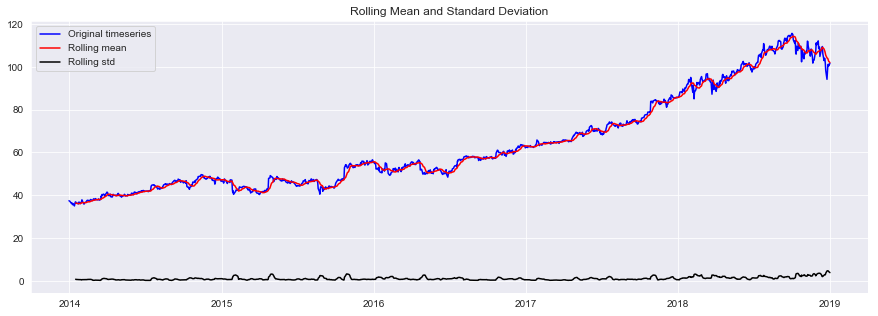

Result of Dicky-Fuller Test
Test Statistics             0.071441
p-values                    0.964056
No of lags                  8.000000
No of observations       1250.000000
Critical values (1%)       -3.435592
Critical values (5%)       -2.863855
Critical values (10%)      -2.568003
dtype: float64


In [19]:
test_stationary(train['Close'])

In [20]:
## Removing the trend
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

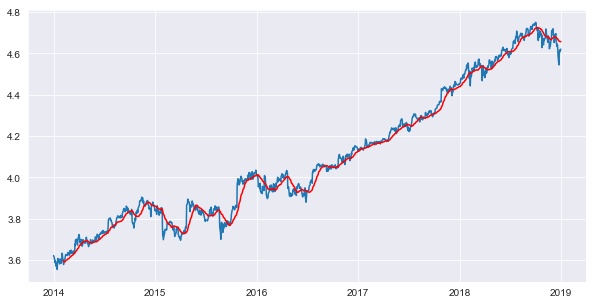

In [21]:
moving_avg = train_log.rolling(24).mean() # To see there is any trend.
plt.figure(figsize=(10,5))
plt.plot(train_log)
plt.plot(moving_avg, color='red')
plt.show()

In [22]:
train_log_moving_avg_diff =  train_log-moving_avg  # To remove the trend

In [23]:
train_log_moving_avg_diff.dropna(inplace=True)


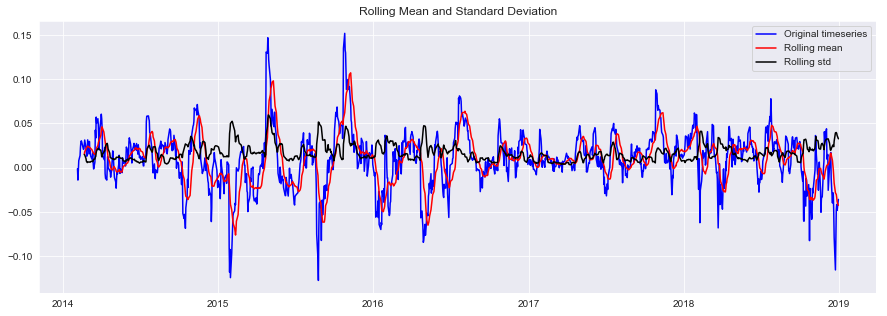

Result of Dicky-Fuller Test
Test Statistics         -7.985853e+00
p-values                 2.550263e-12
No of lags               0.000000e+00
No of observations       1.235000e+03
Critical values (1%)    -3.435656e+00
Critical values (5%)    -2.863883e+00
Critical values (10%)   -2.568018e+00
dtype: float64


In [24]:
test_stationary(train_log_moving_avg_diff)

In [25]:
##Stabilised the mean
train_log_diff =  train_log - train_log.shift(1)

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [27]:
decomposition = seasonal_decompose(pd.DataFrame(train_log).Close.values, freq = 24)

In [28]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

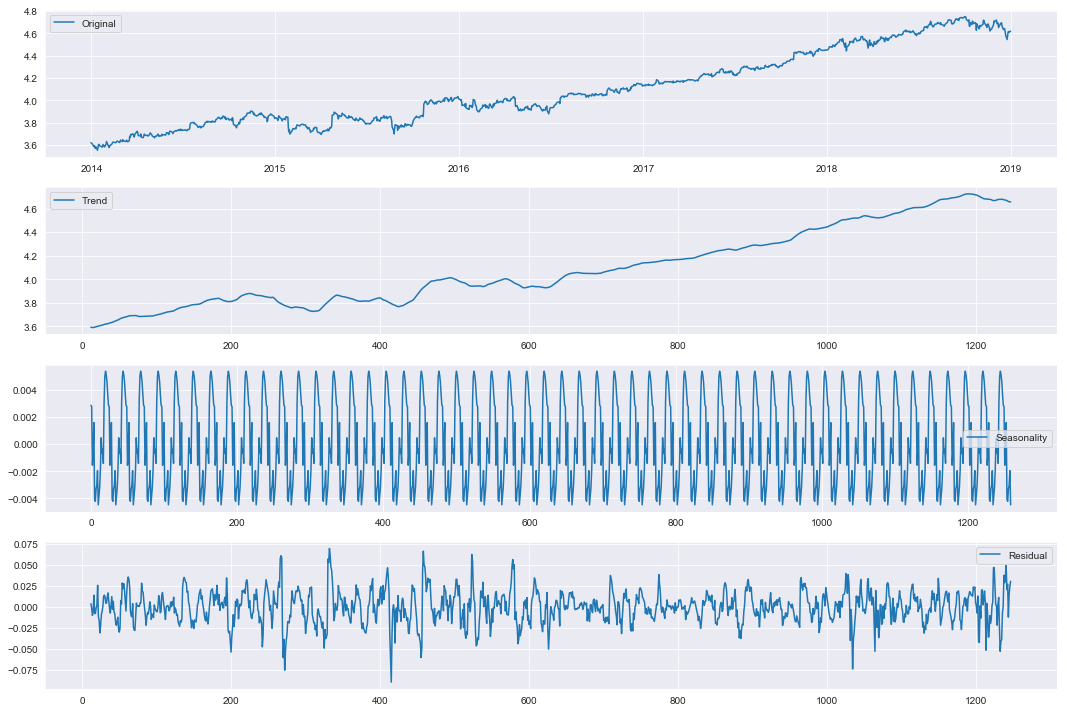

In [29]:
#plot the trend, seasonality and residual
plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout() 
plt.show()

In [30]:
# To check the stationary of residual
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['Date'] = train_log.index
train_log_decompose.set_index('Date', inplace = True)
train_log_decompose.dropna(inplace = True)


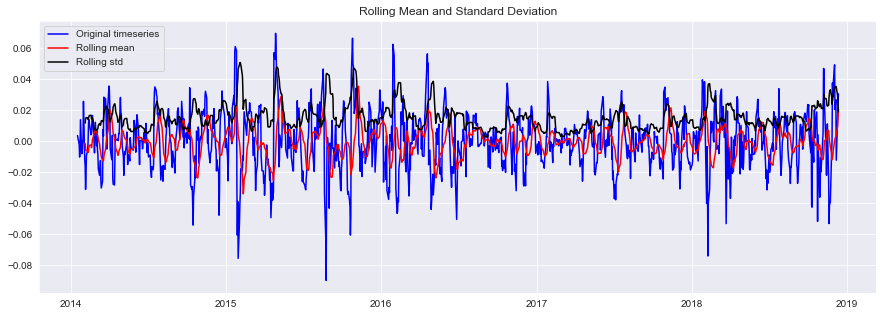

Result of Dicky-Fuller Test
Test Statistics         -1.509126e+01
p-values                 8.186789e-28
No of lags               7.000000e+00
No of observations       1.227000e+03
Critical values (1%)    -3.435691e+00
Critical values (5%)    -2.863898e+00
Critical values (10%)   -2.568026e+00
dtype: float64


In [31]:
test_stationary(train_log_decompose[0])

In [32]:
residual_stationary = train_log_decompose[0] - train_log_decompose[0].shift(1)

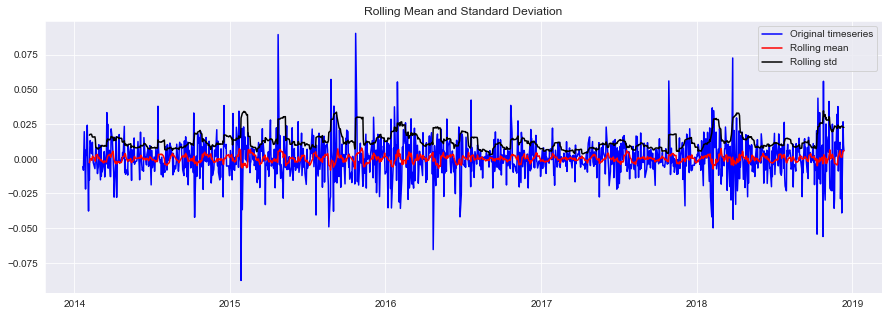

Result of Dicky-Fuller Test
Test Statistics         -1.241966e+01
p-values                 4.164405e-23
No of lags               2.300000e+01
No of observations       1.210000e+03
Critical values (1%)    -3.435766e+00
Critical values (5%)    -2.863932e+00
Critical values (10%)   -2.568043e+00
dtype: float64


In [33]:
test_stationary(residual_stationary.dropna())

## Model Building

In [34]:
from statsmodels.tsa.arima_model import ARIMA

In [35]:
from statsmodels.tsa.stattools import acf, pacf

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


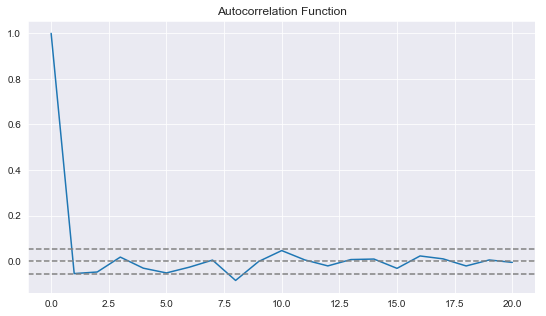

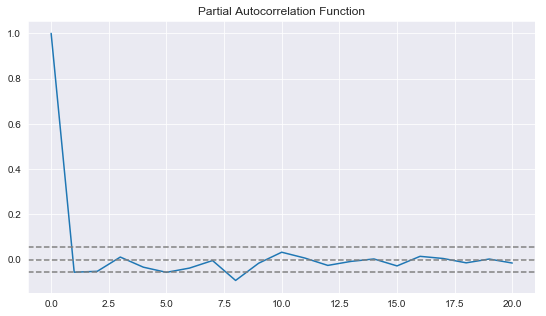

<Figure size 432x288 with 0 Axes>

In [36]:
lag_acf = acf(train_log_diff.dropna(), nlags=20)
lag_pacf = pacf(train_log_diff.dropna(), nlags=20, method='ols')

plt.figure(figsize=(20,5))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()


plt.figure(figsize=(20,5))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()
plt.tight_layout()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


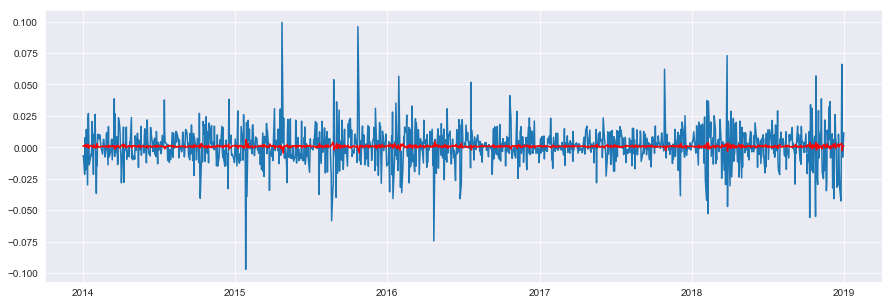

In [37]:
from statsmodels.tsa.arima_model import ARIMA
##AR Model
model = ARIMA(train_log, order=(1, 1, 0), freq=train_log.index.inferred_freq)  
results_AR = model.fit(disp=-1) 
plt.figure(figsize=(15,5))
plt.plot(train_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


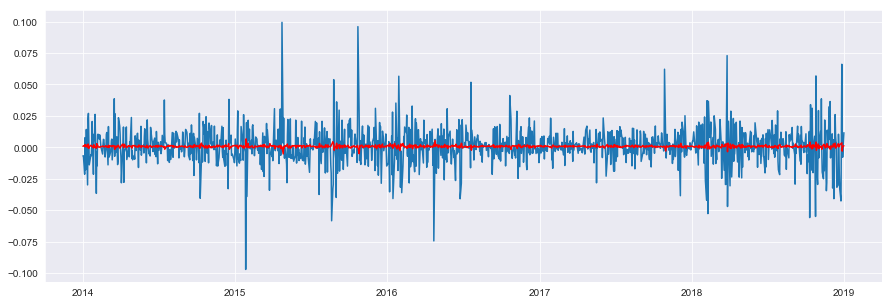

In [38]:
## MA Model
model = ARIMA(train_log,order=(0, 1, 1), freq=train_log.index.inferred_freq)  
results_MA = model.fit(disp=-1)  
plt.figure(figsize = (15,5))
plt.plot(train_log_diff.dropna())
plt.plot(results_MA.fittedvalues, color='red')
plt.show()

In [39]:
model = ARIMA(train_log, order=(1, 1, 1), freq=train_log.index.inferred_freq)  
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1258
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3542.166
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 20 Jan 2020   AIC                          -7076.332
Time:                        17:05:35   BIC                          -7055.783
Sample:                             1   HQIC                         -7068.609
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      3.084      0.002       0.000       0.001
ar.L1.D.Close     0.8526      0.095      8.968      0.000       0.666       1.039
ma.L1.D.Close    -0.9055      0.079    -

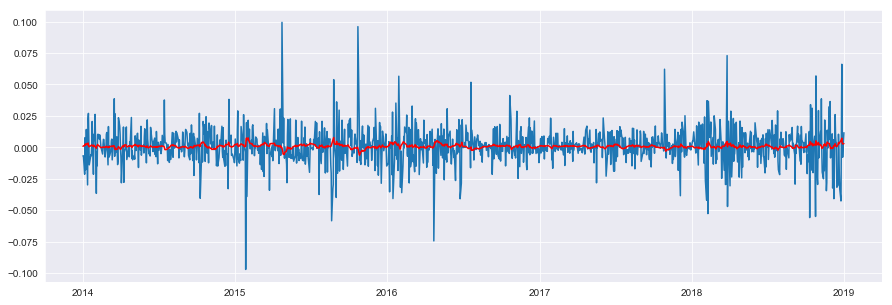

In [40]:
plt.figure(figsize=(15,5))
plt.plot(train_log_diff.dropna())
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.show()

In [41]:
test_log_diff = test_log - test_log.shift(1)

In [42]:
fc, se, conf = results_ARIMA.forecast(252, alpha=0.05)  # 95% conf

In [43]:
## Pandas series
forecast_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0],index=test.index)
upper_series = pd.Series(conf[:,1],index=test.index)

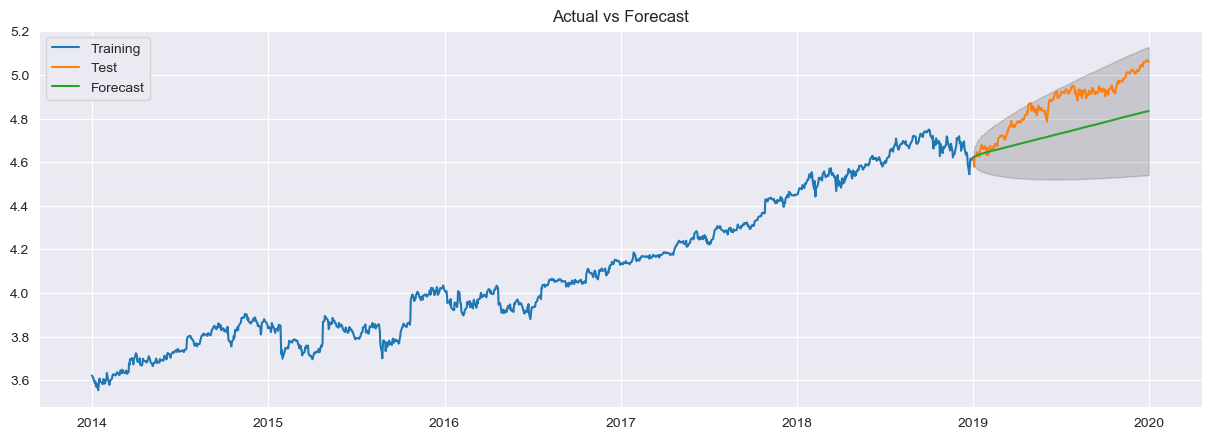

In [44]:
#Plot
plt.figure(figsize=(15,5),dpi=100)
plt.plot(train_log, label='Training')
plt.plot(test_log, label ='Test')
plt.plot(forecast_series, label='Forecast')
plt.fill_between(lower_series.index,lower_series,upper_series,color='k',alpha=0.15)
plt.title('Actual vs Forecast')
plt.legend(loc='best')
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error

In [46]:
rms = np.sqrt(mean_squared_error(test_log,forecast_series))
print("RMSE: ", rms)

RMSE:  0.14535938160033376


### Uisng Holt-Winter Method

In [48]:
from statsmodels.tsa.api import ExponentialSmoothing

In [49]:
test_copy=test['Close']

In [110]:
fit1 = ExponentialSmoothing(train_log,seasonal_periods= 12, trend='add', seasonal='add').fit()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [118]:
forecast_holt = fit1.forecast(len(test))

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [112]:
forecast_holt_s= list(forecast_holt)


In [113]:
prediction_holt=pd.DataFrame(index=test.index,columns=['Prediction'])
prediction_holt['Prediction']=forecast_holt_s


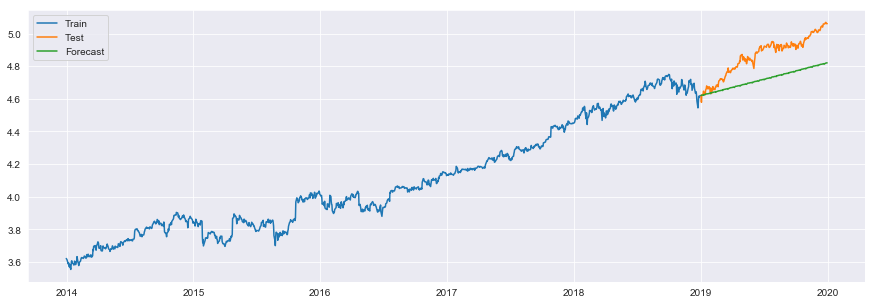

In [115]:
plt.figure(figsize=(15,5))
plt.plot(train_log, label="Train")
plt.plot(test_log, label ='Test')
plt.plot(prediction_holt['Prediction'], label='Forecast')
plt.legend(loc='best')
plt.show()

In [116]:
rms = np.sqrt(mean_squared_error(test_log,prediction_holt['Prediction']))
print("RMSE: ", rms)

RMSE:  0.1573236950433104
